# Compare latent space to high-dimensional space

In [57]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [58]:
from preprocessing_functions import pad_spectro, calc_zscore, create_padded_data
from evaluation_functions import get_knn, make_nn_stats_dict, make_statstabs

In [59]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

In [60]:
dftype = "reduced"
spec_df = pd.read_pickle(os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl"))

labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

specs = spec_df.spectrograms
specs = [calc_zscore(x) for x in specs]
original_embedding = create_padded_data(specs)

## Compare embedding score S for different k's

In [61]:
# Make 5 UMAPs

n_times=5
embeddings_dict={}
for i in range(n_times):
    reducer = umap.UMAP(low_memory=True, min_dist=0, metric= "euclidean", n_components = 5)
    embeddings_dict[i] = reducer.fit_transform(original_embedding)
  

In [62]:
# UMAP space

ks = [1,3,5,8,10,15,20,30,40]
ks = [1,3,5,8,10,15,20,30,40,50,100,200]

metrics_tab = np.zeros((len(ks)*n_times,2))

i=0
for embedding in embeddings_dict.values():
    indices, distances = get_knn(np.max(np.asarray(ks)),embedding)
    for k_num,k in enumerate(ks):
        these_indices = [x[0:k] for x in indices]
        nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
        stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels, k)

        metrics_tab[i,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
        metrics_tab[i,1] = np.mean(np.diagonal(stats_tab_norm))
        i+=1
        
metrics_tab_df = pd.DataFrame(metrics_tab)
metrics_tab_df['k'] = ks*n_times
metrics_tab_df.columns = ['S', 'Snorm', 'k']

means_df = metrics_tab_df.groupby('k').mean()
stds_df = metrics_tab_df.groupby('k').std()

In [37]:
# Original space

metrics_tab_f = np.zeros((len(ks),2))

indices, distances = get_knn(np.max(np.asarray(ks)),original_embedding)

for k_num,k in enumerate(ks):
    these_indices = [x[0:k] for x in indices]
    nn_stats_dict = make_nn_stats_dict(calltypes, labels, these_indices)
    stats_tab, stats_tab_norm = make_statstabs(nn_stats_dict, calltypes, labels,k)

    metrics_tab_f[k_num,0] = np.mean(np.diagonal(stats_tab.iloc[:-1,]))
    metrics_tab_f[k_num,1] = np.mean(np.diagonal(stats_tab_norm))

metrics_tab_f_df = pd.DataFrame(metrics_tab_f)
metrics_tab_f_df['k'] = ks
metrics_tab_f_df.columns = ['S', 'Snorm', 'k']

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-07_comparison_to_original.jpg


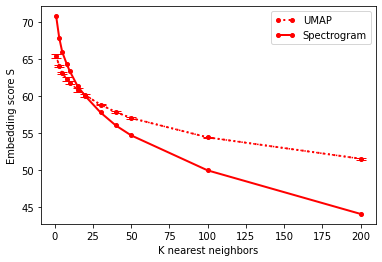

In [40]:
var ='S'
plt.plot(ks, means_df[var], color = 'red', marker='o', linestyle='dotted', linewidth=2, markersize=4,label='UMAP')
plt.errorbar(ks, means_df[var], yerr=stds_df[var], linestyle='dotted', capsize=5, color = 'red')

plt.plot(ks, metrics_tab_f_df[var], marker='o',linewidth=2, markersize=4, color ='red',label='Spectrogram')


plt.legend(numpoints=2)

plt.ylabel('Embedding score '+var)
plt.xlabel('K nearest neighbors')

outname=os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_comparison_to_original.jpg')
print(outname)
plt.savefig(outname)

## Original space between and within distances

In [41]:
from scipy.spatial.distance import pdist, squareform

In [42]:
distmat_original = squareform(pdist(original_embedding, metric='euclidean'))
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
    x=distmat_original[np.where(labels==calltype)]
    x = np.transpose(x)  
    y = x[np.where(labels==calltype)]
   
    self_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1],k = 1)]
    y = x[np.where(labels!=calltype)]
    other_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1], k = 1)]

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-08_distanceswithinwithout_reduced_original.jpg


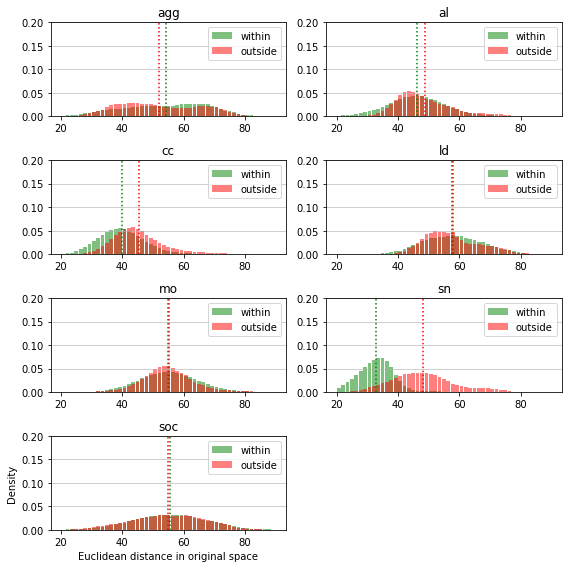

In [63]:
plt.figure(figsize=(8, 8))
i=1

xmin=20
xmax=90
nbins=50
    
for calltype in calltypes:
    
    plt.subplot(4, 2, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              #bins='auto', color='green',
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="outside", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              #bins='auto', color='red',
                              alpha=0.5, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
    s, pval = scipy.stats.ttest_ind(self_dists[calltype],other_dists[calltype])

    if pval<0.01:
        pval = "p<0.01"
    else:
        pval = "p="+str(round(pval,2))

    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    #plt.title(calltype+" ("+pval+")")
    plt.title(calltype)
    #plt.xlim(xmin,xmax)
    plt.ylim(0, 0.2)
    if i==len(calltypes):      
        plt.ylabel('Density')
        plt.xlabel('Euclidean distance in original space')

    i=i+1

plt.tight_layout()
outname=os.path.join(os.path.sep, FIGURES, 'distanceswithinwithout_reduced_original.jpg')
print(outname)
plt.savefig(outname)